In [45]:
import numpy as np
from catboost import Pool, CatBoost
from catboost.datasets import titanic
import os 
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier  # using SGDClassifier for training incrementally
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_colwidth', 100)

first read the dataset

In [46]:
train_df, test_df = titanic()

In [47]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [48]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature type

1. Numerical
	- cope with missing value (fill with mean/ drop / etc)
	- put into different bins
	- use scaler 

2. Categorical
   - cope with missing / unseen (fill with default / drop / etc)
   - Onehot encode (could be converted into embeddings...)
   - Ordinal encode
   - label encode
  

## Data check
data type, unique_num, data range, is_null, distribution, etc

In [49]:
print(train_df.columns)
print(test_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [50]:
# check missing value stats
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [51]:
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [52]:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [53]:
# to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
# X.drop(to_drop, axis=1, inplace=True)
# test_df.drop(to_drop, axis=1, inplace=True)

In [54]:
# X.columns

In [55]:
categorical_features = [
	'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
]
numerical_features = ['Age', 'Fare']
label = 'Survived'

X = train_df[numerical_features + categorical_features]
y = train_df[label]

test_df = test_df[numerical_features + categorical_features]


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = test_df

In [57]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

gbdt_model = CatBoostClassifier(iterations=100, 
								learning_rate=0.1, 
								depth=4,
								cat_features=categorical_features,
								verbose=50)

gbdt_model.fit(X_train, y_train)

# Extract leaf indices as new features
train_leaf_indices = gbdt_model.calc_leaf_indexes(X_train)
val_leaf_indices = gbdt_model.calc_leaf_indexes(X_val)
test_leaf_indices = gbdt_model.calc_leaf_indexes(X_test)


0:	learn: 0.6623506	total: 3.84ms	remaining: 380ms
50:	learn: 0.4175910	total: 38.8ms	remaining: 37.3ms
99:	learn: 0.4017291	total: 64.1ms	remaining: 0us


In [58]:
train_leaf_indices.shape, val_leaf_indices.shape, test_leaf_indices.shape

((668, 100), (223, 100), (418, 100))

In [59]:
# train_leaf_indices[:10]

In [60]:
encoder = OneHotEncoder(handle_unknown='ignore')
train_encoded_features = encoder.fit_transform(train_leaf_indices)
val_encoded_features = encoder.transform(val_leaf_indices)
test_encoded_features = encoder.transform(test_leaf_indices)

In [64]:
train_encoded_features[:3]

<3x667 sparse matrix of type '<class 'numpy.float64'>'
	with 300 stored elements in Compressed Sparse Row format>

In [65]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=100)
logistic_regression_model.fit(train_encoded_features, y_train)
# Evaluate the model
print("Training accuracy:", logistic_regression_model.score(train_encoded_features, y_train))
print("Testing accuracy:", logistic_regression_model.score(val_encoded_features, y_val))

Training accuracy: 0.8877245508982036
Testing accuracy: 0.8609865470852018


/Users/terry/opt/anaconda3/envs/shrec/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


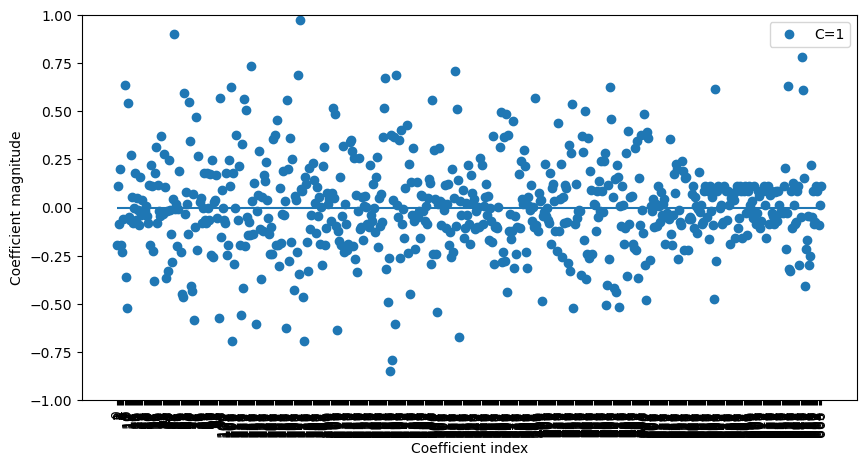

In [72]:
# plot the parameter of logistic regression
plt.figure(figsize=(10, 5))
plt.plot(logistic_regression_model.coef_.T, 'o', label="C=1")
plt.xticks(range(train_encoded_features.shape[1]), rotation=90)
plt.hlines(0, 0, train_encoded_features.shape[1])
plt.ylim(-1, 1)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.show()


(array([139., 141.,  97.,  60.,  60.,  36.,  30.,  29.,  12.,  14.,  13.,
         11.,  10.,   4.,   5.,   1.,   2.,   1.,   1.,   1.]),
 array([4.55801996e-05, 4.87309885e-02, 9.74163968e-02, 1.46101805e-01,
        1.94787213e-01, 2.43472622e-01, 2.92158030e-01, 3.40843438e-01,
        3.89528847e-01, 4.38214255e-01, 4.86899663e-01, 5.35585072e-01,
        5.84270480e-01, 6.32955888e-01, 6.81641297e-01, 7.30326705e-01,
        7.79012113e-01, 8.27697522e-01, 8.76382930e-01, 9.25068338e-01,
        9.73753747e-01]),
 <BarContainer object of 20 artists>)

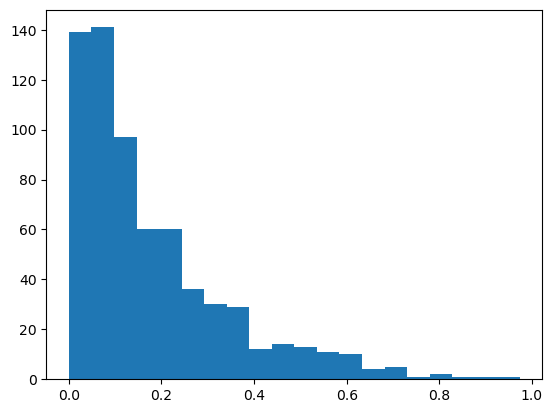

In [69]:
# get the importance of lr model
importance = logistic_regression_model.coef_[0]
importance = np.abs(importance)
# plot the distribution
plt.hist(importance, bins=20)

In [73]:
# # analyze feature importance
# feature_importances = gbdt_model.get_feature_importance(X_train)
# feature_names = X_train.columns
# for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
# 	print('{}: {}'.format(name, score))